In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
import ast
from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [ ]:
###########################
# This notebook loads StatsBomb's open data and calculates the various more advanced features that we'll ues as heuristics - it is the same as the previous augmentation notebook, but incorporates our idea of representing defenders through Gaussians. It covers the four heads of features we're looking to add: location-based, goalkeeper, and defensive pressure statistics, as well as features based on our various hypotheses.
###########################

In [2]:
all_shots = pd.read_csv("./data/all_shots.csv")

In [3]:
all_shots.shape

(84065, 122)

In [4]:
all_shots = all_shots[~all_shots["competition_id"].isin(["FIFA U20 World Cup", "North American League", "Liga Profesional", "Indian Super League"])].drop(columns=all_shots.columns[all_shots.nunique() == 0]).sort_values(by=["match_id", "timestamp"])
all_shots.nunique()

season_id                   42
match_id                  3312
duration                 77926
id                       83929
index                     4465
location                 56583
minute                     139
off_camera                   1
out                          1
period                       5
play_pattern                 9
player                    5638
player_id                 5637
position                    25
possession                 290
possession_team            288
possession_team_id         291
related_events           83929
second                      60
shot_aerial_won              1
shot_body_part               4
shot_end_location        51584
shot_first_time              1
shot_freeze_frame        82866
shot_key_pass_id         59111
shot_one_on_one              1
shot_outcome                 8
shot_statsbomb_xg        82417
shot_technique               7
shot_type                    5
team                       288
team_id                    291
timestam

In [5]:
all_shots[["season_id", "match_id", "id", "index", "location", "minute", "period", "player", "player_id", "position", "possession", "possession_team", "possession_team_id", "second", "team", "team_id", "timestamp", "competition_id", "shot_outcome"]].sort_values(by=["match_id", "timestamp"])

,season_id,match_id,id,index,location,minute,period,player,player_id,position,possession,possession_team,possession_team_id,second,team,team_id,timestamp,competition_id,shot_outcome
15349,2018/2019,7298.0,9b82eaa3-2048-4157-aa9a-eabeb4fa0ebe,42.0,"[115.0, 25.0]",0.0,1.0,Francesca Kirby,4641.0,Right Center Forward,4.0,Chelsea FCW,971.0,47.0,Chelsea FCW,971.0,00:00:47.620,FA Women's Super League,Blocked
15366,2018/2019,7298.0,62a616ea-6791-422c-af80-1683d22bb9f5,2096.0,"[114.0, 34.0]",47.0,2.0,Ramona Bachmann,4659.0,Right Center Forward,107.0,Chelsea FCW,971.0,59.0,Chelsea FCW,971.0,00:02:59.118,FA Women's Super League,Saved
15367,2018/2019,7298.0,3279e6e0-c796-4871-aaaa-75344dc903b8,2136.0,"[115.0, 41.0]",48.0,2.0,Nikita Parris,4654.0,Right Wing,120.0,Manchester City WFC,746.0,41.0,Manchester City WFC,746.0,00:03:41.638,FA Women's Super League,Goal
15368,2018/2019,7298.0,28c07afb-53b7-497f-9bb0-1c586c27e2de,2154.0,"[109.0, 39.0]",49.0,2.0,Francesca Kirby,4641.0,Left Center Forward,121.0,Chelsea FCW,971.0,37.0,Chelsea FCW,971.0,00:04:37.118,FA Women's Super League,Blocked
15350,2018/2019,7298.0,25dace9c-6bf8-4ada-8a4f-bad0485141c9,237.0,"[109.0, 51.0]",5.0,1.0,Francesca Kirby,4641.0,Right Center Forward,15.0,Chelsea FCW,971.0,12.0,Chelsea FCW,971.0,00:05:12.780,FA Women's Super League,Blocked
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7840,2023,3923881.0,11ac245b-fffb-43b9-a9ab-2953e50e1759,1011.0,"[112.1, 44.3]",37.0,1.0,William Troost-Ekong,5455.0,Center Back,58.0,Nigeria,775.0,1.0,Nigeria,775.0,00:37:01.662,African Cup of Nations,Goal
7851,2023,3923881.0,bded325e-4b96-41d1-992d-3942344b5902,2483.0,"[102.9, 46.8]",89.0,2.0,Kelechi Promise Iheanacho,3708.0,Right Wing,149.0,Nigeria,775.0,12.0,Nigeria,775.0,00:44:12.865,African Cup of Nations,Blocked
7852,2023,3923881.0,3e369ccb-5ae2-45cf-8eb8-f24aec5e9e9d,2623.0,"[97.4, 55.3]",93.0,2.0,Wilfried Stephane Singo,36539.0,Right Back,159.0,Côte d'Ivoire,3374.0,55.0,Côte d'Ivoire,3374.0,00:48:55.619,African Cup of Nations,Wayward
7841,2023,3923881.0,be20d643-eda2-46b4-bd3c-c305e5ce7725,1348.0,"[87.2, 34.1]",49.0,1.0,Seko Fofana,7791.0,Left Center Midfield,82.0,Côte d'Ivoire,3374.0,28.0,Côte d'Ivoire,3374.0,00:49:28.253,African Cup of Nations,Saved


In [6]:
all_passes = pd.read_csv("./data/all_passes.csv")

In [7]:
all_passes

,season_id,match_id,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,goalkeeper_success_in_play,shot_follows_dribble,half_start_late_video_start,player_off_permanent,pass_backheel,goalkeeper_lost_in_play,half_end_early_video_end,goalkeeper_saved_to_post,goalkeeper_penalty_saved_to_post,shot_kick_off
0,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687132,2019,69161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687133,2019,69161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687134,2019,69161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687135,2019,69161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
all_shots.nunique()

season_id                   42
match_id                  3312
duration                 77926
id                       83929
index                     4465
location                 56583
minute                     139
off_camera                   1
out                          1
period                       5
play_pattern                 9
player                    5638
player_id                 5637
position                    25
possession                 290
possession_team            288
possession_team_id         291
related_events           83929
second                      60
shot_aerial_won              1
shot_body_part               4
shot_end_location        51584
shot_first_time              1
shot_freeze_frame        82866
shot_key_pass_id         59111
shot_one_on_one              1
shot_outcome                 8
shot_statsbomb_xg        82417
shot_technique               7
shot_type                    5
team                       288
team_id                    291
timestam

In [9]:
all_shots['shot_key_pass_id'].notna().value_counts()

True     59111
False    24818
Name: shot_key_pass_id, dtype: int64

In [10]:
all_shots["related_events"]

15349    ['a1c408ce-f949-4dfd-801f-08ed281da0cc', 'e3be...
15366             ['b5abbcf4-f58b-412c-b55e-7114812fa2f8']
15367             ['4f7c3d8d-a93e-49f5-9c49-c5c29a6f3d86']
15368    ['1a3a5de3-19b3-4ab7-b707-1f4b90c8a5e0', '534f...
15350    ['7d64a307-d6e2-46e7-97cd-211198e0537e', '8bc7...
                               ...                        
7840     ['4708852e-5db3-4c35-be3a-1de2d1304134', '9158...
7851     ['76574587-dc10-4538-be43-aae7d0cfcbe5', 'd4b7...
7852              ['663015a0-57c5-400f-8ced-bf98f9f49ce4']
7841              ['6ecadb13-fc59-4753-9640-df9b5d70b3e8']
7853              ['edb432f3-df04-465b-850e-92ed23209714']
Name: related_events, Length: 83929, dtype: object

In [11]:
# Function to check if each item in the list is in the column
def get_items_in_column(lst, column):
    found_items = []
    for item in lst:
        if item in column.values:
            found_items.append(item)
    return found_items

In [12]:
key_passes = all_passes[all_passes["id"].isin(all_shots['shot_key_pass_id'])]

In [13]:
key_passes

,season_id,match_id,ball_receipt_outcome,ball_recovery_recovery_failure,block_deflection,carry_end_location,clearance_aerial_won,clearance_body_part,clearance_head,clearance_left_foot,...,goalkeeper_success_in_play,shot_follows_dribble,half_start_late_video_start,player_off_permanent,pass_backheel,goalkeeper_lost_in_play,half_end_early_video_end,goalkeeper_saved_to_post,goalkeeper_penalty_saved_to_post,shot_kick_off
46,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,2015/2016,3890561.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234,2015/2016,3890505.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,2015/2016,3890505.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,2015/2016,3890505.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686852,2019,69205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686919,2019,69205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686929,2019,69205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686981,2019,69161.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
key_passes[["duration", "pass_angle", "pass_type", "pass_height", "pass_length", "pass_assisted_shot_id"]]

,duration,pass_angle,pass_type,pass_height,pass_length,pass_assisted_shot_id
46,1.707827,-1.850475,Corner,High Pass,39.848340,fd99f442-49ae-4724-87e8-2512e4a5d9c6
84,1.635672,1.716809,Corner,High Pass,37.802250,4aaf9747-c33d-4f76-bb0f-d25ad1ebe7c6
234,1.320689,1.778707,Corner,High Pass,37.303352,749a19ff-d599-4170-a095-79b9865e2b06
268,1.350540,-1.871810,Corner,Low Pass,35.077200,37cdb09d-6504-48cb-a6cc-217790d53b4b
307,1.571437,-1.551568,Recovery,High Pass,10.401923,cffe1d92-0692-47ad-a71b-208c8a52dcc0
...,...,...,...,...,...,...
686852,2.271377,-1.125219,Recovery,Ground Pass,22.274874,2c92a25a-2014-4080-b8fd-b69d72092898
686919,1.689300,0.895606,Free Kick,High Pass,34.717430,828295e4-feac-43c4-8b4a-47617f6d2408
686929,1.788300,-1.394087,Free Kick,High Pass,42.664387,58997323-8e35-474d-815c-7926e1e143ba
686981,1.010200,1.630133,Corner,High Pass,30.353418,4201f68c-764d-45bd-bcfb-96470a72c2e8


In [15]:
key_passes["pass_duration"] = key_passes["duration"]

all_shots = pd.merge(all_shots, key_passes[["pass_duration", "pass_angle", "pass_type", "pass_height", "pass_length", "pass_assisted_shot_id"]], how='left', left_on='id', right_on='pass_assisted_shot_id', suffixes=("", ""))
all_shots = all_shots.drop("pass_assisted_shot_id", axis=1)

In [16]:
possession_passes = all_passes.groupby(["match_id", "possession"]).agg({
    'match_id': 'first',
    'possession': 'first',
    'duration': 'count'
}).reset_index(drop=True)
possession_passes["num_passes"] = possession_passes["duration"]
possession_passes = possession_passes.drop("duration", axis=1)

all_shots = pd.merge(all_shots, possession_passes, how='left', on=["match_id", "possession"])

In [17]:
all_shots

,season_id,match_id,duration,id,index,location,minute,off_camera,out,period,...,shot_saved_off_target,shot_saved_to_post,shot_follows_dribble,shot_kick_off,pass_duration,pass_angle,pass_type,pass_height,pass_length,num_passes
0,2018/2019,7298.0,0.560000,9b82eaa3-2048-4157-aa9a-eabeb4fa0ebe,42.0,"[115.0, 25.0]",0.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018/2019,7298.0,0.613000,62a616ea-6791-422c-af80-1683d22bb9f5,2096.0,"[114.0, 34.0]",47.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018/2019,7298.0,0.400000,3279e6e0-c796-4871-aaaa-75344dc903b8,2136.0,"[115.0, 41.0]",48.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018/2019,7298.0,0.120000,28c07afb-53b7-497f-9bb0-1c586c27e2de,2154.0,"[109.0, 39.0]",49.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,1.12,0.927295,Interception,Low Pass,10.0,1.0
4,2018/2019,7298.0,0.400000,25dace9c-6bf8-4ada-8a4f-bad0485141c9,237.0,"[109.0, 51.0]",5.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83924,2023,3923881.0,1.188547,11ac245b-fffb-43b9-a9ab-2953e50e1759,1011.0,"[112.1, 44.3]",37.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
83925,2023,3923881.0,0.314267,bded325e-4b96-41d1-992d-3942344b5902,2483.0,"[102.9, 46.8]",89.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
83926,2023,3923881.0,1.510618,3e369ccb-5ae2-45cf-8eb8-f24aec5e9e9d,2623.0,"[97.4, 55.3]",93.0,NaN,True,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
83927,2023,3923881.0,1.050901,be20d643-eda2-46b4-bd3c-c305e5ce7725,1348.0,"[87.2, 34.1]",49.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# extract relevant attributes from the all_shots dataframe
data = pd.DataFrame()

# time attributes
data["period"] = all_shots["period"]
data["minute"] = all_shots["minute"]
data["possession"] = all_shots["possession"]
data["duration"] = all_shots["duration"]
data["season_id"] = all_shots["season_id"]
data["match_id"] = all_shots["match_id"]
data["timestamp"] = all_shots["timestamp"]
data["team"] = all_shots["team"]

data = data.sort_values(by=["match_id", "timestamp"])

In [19]:
# qualitative attributes
data["play_pattern"] = all_shots["play_pattern"]
data["position"] = all_shots["position"]

In [20]:
# shot attributes
data["location_x"] = all_shots["location"].apply(lambda x: ast.literal_eval(x)[0])
data["location_x_distance"] = 120 - data["location_x"]
data["location_y"] = all_shots["location"].apply(lambda x: ast.literal_eval(x)[1])
data["location_y_distance"] = abs(data["location_y"] - 40)
data["duration"] = all_shots["duration"].apply(lambda x: x if x < 100 else 0)
data["technique"] = all_shots["shot_technique"]
data["body_part"] = all_shots["shot_body_part"]
data["type"] = all_shots["shot_type"]
data["is_penalty"] = all_shots["shot_type"] == "Penalty"
data["is_header"] = all_shots["shot_body_part"] == "Head"

In [21]:
# shot modifiers
data["first_time"] = all_shots["shot_first_time"].fillna(False)
data["open_goal"] = all_shots["shot_open_goal"].fillna(False)
data["one_on_one"] = all_shots["shot_one_on_one"].fillna(False)
data["aerial_won"] = all_shots["shot_aerial_won"].fillna(False)
data["follows_dribble"] = all_shots["shot_follows_dribble"].fillna(False)
data["under_pressure"] = all_shots["under_pressure"].fillna(False)

In [22]:
# preceding pass attributes
data["pass_duration"] = all_shots["pass_duration"].fillna(all_shots["pass_duration"].mean())
data["pass_angle"] = all_shots["pass_angle"].fillna(all_shots["pass_angle"].mean())
data["pass_type"] = all_shots["pass_type"].fillna("Missing")
data["pass_height"] = all_shots["pass_height"].fillna("Missing")
data["pass_length"] = all_shots["pass_length"].fillna(all_shots["pass_length"].mean())
data["num_passes"] = all_shots["num_passes"].fillna(0)

In [23]:
# locations for defensive/goalkeeper attributes
locations = pd.DataFrame()
locations["opponents"] = all_shots["shot_freeze_frame"].fillna('[{"location": [], "position": {"name": ""}, "teammate": False}]').apply(lambda frame: [[player["location"], player["position"]["name"]] for player in ast.literal_eval(frame) if not player["teammate"]])
locations["shot"] = tuple(zip(data["location_x"], data["location_y"]))
locations["goalkeeper"] = locations["opponents"].apply(lambda frame: [player[0] for player in frame if player[1] == "Goalkeeper"]).apply(lambda x: x[0] if len(x) != 0 else [-1, -1])
locations

,opponents,shot,goalkeeper
0,"[[[112.0, 28.0], Right Back], [[103.0, 50.0], ...","(115.0, 25.0)","[120.0, 26.0]"
1,"[[[111.0, 41.0], Right Center Back], [[97.0, 4...","(114.0, 34.0)","[119.0, 39.0]"
2,"[[[106.0, 21.0], Right Midfield], [[112.0, 46....","(115.0, 41.0)","[118.0, 40.0]"
3,"[[[109.0, 31.0], Right Center Midfield], [[103...","(109.0, 39.0)","[119.0, 41.0]"
4,"[[[106.0, 42.0], Right Center Midfield], [[115...","(109.0, 51.0)","[119.0, 40.0]"
...,...,...,...
83924,"[[[114.0, 43.2], Right Center Midfield], [[112...","(112.1, 44.3)","[119.0, 41.7]"
83925,"[[[96.3, 37.3], Right Wing], [[106.0, 44.9], R...","(102.9, 46.8)","[116.9, 41.4]"
83926,"[[[117.6, 41.3], Goalkeeper], [[95.6, 56.9], C...","(97.4, 55.3)","[117.6, 41.3]"
83927,"[[[101.3, 20.0], Right Wing Back], [[95.3, 13....","(87.2, 34.1)","[118.5, 39.4]"


In [24]:
def point_in_triangle(point, a, b, c):
    as_x = point[0] - a[0]
    as_y = point[1] - a[1]
    s_ab = ((b[0] - a[0]) * as_y) - ((b[1] - a[1]) * as_x) > 0

    if (((c[0] - a[0]) * as_y) - ((c[1] - a[1]) * as_x) > 0) == s_ab \
            or (((c[0] - b[0]) * (point[1] - b[1])) - ((c[1] - b[1]) * (point[0] - b[0])) > 0) != s_ab:
        return False
    else:
        return True

In [25]:
def angle_between_sides(a, b, c):
    cos_theta = (a**2 + b**2 - c**2) / (2 * a * b)
    theta = math.degrees(math.acos(cos_theta))
    return theta

In [26]:
def best_distance(point) :

    line = (0, 8)
    left_line = (point[0] - 120, point[1] - 36)
    right_line = (point[0] - 120, point[1] - 44)

    line_dot_left = line[0] * left_line[0] + line[1] * left_line[1]
    line_dot_right = line[0] * right_line[0] + line[1] * right_line[1]

    if line_dot_right > 0:
        x = 120 - point[0]
        y = 44 - point[1]
        return math.sqrt(x * x + y * y)
    elif line_dot_left < 0:
        x = 120 - point[0]
        y = 36 - point[1]
        return math.sqrt(x * x + y * y)
    else:
        return 120 - point[0]

In [27]:
# defensive/goalkeeper attributes
data["defenders_3m_radius"] = locations.apply(lambda shot: (len([defender for defender in shot["opponents"] if ((defender[0][0]-shot["shot"][0])**2 + (defender[0][1]-shot["shot"][1])**2) < 3**2])) if shot["opponents"] != [[[], '']] else -1, axis=1)
data["defenders_triangle"] = locations.apply(lambda shot: (len([defender for defender in shot["opponents"] if point_in_triangle(defender[0], shot["shot"], [120, 36], [120, 44])])) if shot["opponents"] != [[[], '']] else -1, axis=1)

data["goalkeeper_x"] = locations["goalkeeper"].apply(lambda x: x[0])
data["goalkeeper_y"] = locations["goalkeeper"].apply(lambda x: x[1])
data["distance_to_goalie"] = data.apply(lambda x: math.sqrt((x["goalkeeper_x"] - x["location_x"])**2 + (x["goalkeeper_y"] - x["location_y"])**2), axis=1)

In [28]:
# angle/location attributes
points = pd.Series(zip(data['location_x'].replace(120.0, 119.9), data['location_y']))
data["shooting_range"] = points.apply(lambda point: angle_between_sides(math.dist(point, (120, 36)), math.dist((120, 44), point), 8))
data["goal_distance"] = points.apply(lambda point: math.dist(point, (120, 40)))
data["best_distance"] = points.apply(lambda point: best_distance(point))
#data["goalie_error"] = points.apply(lambda point: )

In [29]:
# target variables
data["statsbomb_xg"] = all_shots["shot_statsbomb_xg"].apply(lambda x: float(x))
data["end_location_x"] = all_shots["shot_end_location"].apply(lambda x: ast.literal_eval(x)[0])
data["end_location_y"] = all_shots["shot_end_location"].apply(lambda x: ast.literal_eval(x)[1])
data["is_goal"] = all_shots["shot_outcome"].apply(lambda x: True if x == "Goal" else False)

In [30]:
data["shot_angle"] =  data.apply(lambda x: math.atan2((x["end_location_y"] - x["location_y"]), (x["end_location_x"] - x["location_x"])), axis=1)
data["good_foot"] = data.apply(lambda shot: True if ((shot["body_part"] == "Right Foot" and shot["location_y"] < 42) or (shot["body_part"] == "Left Foot" and shot["location_y"] > 42)) else False, axis=1)

In [31]:
data["shots_so_far"] = all_shots.groupby(["match_id", "team"])["timestamp"].cumcount()
data["xg_so_far"] = all_shots.groupby(["match_id", "team"])["shot_statsbomb_xg"].cumsum()
data["xg_so_far"] = data["xg_so_far"] - data["statsbomb_xg"]

all_goals = all_shots[all_shots["shot_outcome"] == "Goal"]

first_scorers = all_goals.groupby(['match_id']).first()[["team"]]
all_goals["is_first"] = all_goals[['match_id', 'team']].apply(tuple, axis=1).isin(list(zip(first_scorers.index, first_scorers["team"])))

all_goals["first_tally_temp"] = all_goals[all_goals["is_first"] == True].groupby(["match_id", "is_first"]).cumcount()
all_goals["first_tally"] = all_goals.groupby(["match_id"])["first_tally_temp"].fillna(method="ffill")
all_goals.loc[all_goals['first_tally_temp'].isnull() & ~all_goals['first_tally'].isnull(), 'first_tally'] = all_goals.loc[all_goals['first_tally_temp'].isnull() & ~all_goals['first_tally'].isnull(), 'first_tally'] + 1

all_goals["second_tally_temp"] = all_goals[all_goals["is_first"] == False].groupby(["match_id", "is_first"]).cumcount()
all_goals["second_tally"] = all_goals.groupby(["match_id"])["second_tally_temp"].fillna(method="ffill")
all_goals.loc[all_goals['second_tally_temp'].isnull() & ~all_goals['second_tally'].isnull(), 'second_tally'] = all_goals.loc[all_goals['second_tally_temp'].isnull() & ~all_goals['second_tally'].isnull(), 'second_tally'] + 1
all_goals["second_tally"].fillna(0, inplace=True)

all_goals[["season_id", "match_id", "timestamp", "team", "is_first", "first_tally", "second_tally"]].sort_values(by=["match_id", "timestamp"])

,season_id,match_id,timestamp,team,is_first,first_tally,second_tally
2,2018/2019,7298.0,00:03:41.638,Manchester City WFC,True,0.0,0.0
7,2018/2019,7298.0,00:05:46.380,Chelsea FCW,False,1.0,0.0
13,2018/2019,7298.0,00:23:21.100,Chelsea FCW,False,1.0,1.0
26,2018/2019,7298.0,00:40:34.118,Manchester City WFC,True,1.0,2.0
36,2018,7430.0,00:02:42.533,Washington Spirit,True,0.0,0.0
...,...,...,...,...,...,...,...
83889,2023,3923880.0,00:10:33.248,Congo DR,True,4.0,5.0
83891,2023,3923880.0,00:11:20.504,South Africa,False,5.0,5.0
83915,2023,3923881.0,00:16:40.123,Côte d'Ivoire,True,0.0,0.0
83922,2023,3923881.0,00:35:14.269,Côte d'Ivoire,True,1.0,0.0


In [32]:
data["first_tally"] = all_goals["first_tally"]
data["second_tally"] = all_goals["second_tally"]
data[["season_id", "match_id", "timestamp", "team", "is_goal", "shots_so_far", "xg_so_far", "first_tally", "second_tally"]].sort_values(by=["match_id", "timestamp"])

,season_id,match_id,timestamp,team,is_goal,shots_so_far,xg_so_far,first_tally,second_tally
0,2018/2019,7298.0,00:00:47.620,Chelsea FCW,False,0,0.000000,NaN,NaN
1,2018/2019,7298.0,00:02:59.118,Chelsea FCW,False,1,0.018856,NaN,NaN
2,2018/2019,7298.0,00:03:41.638,Manchester City WFC,True,0,0.000000,0.0,0.0
3,2018/2019,7298.0,00:04:37.118,Chelsea FCW,False,2,0.330081,NaN,NaN
4,2018/2019,7298.0,00:05:12.780,Chelsea FCW,False,3,0.433315,NaN,NaN
...,...,...,...,...,...,...,...,...,...
83924,2023,3923881.0,00:37:01.662,Nigeria,True,2,0.121763,2.0,0.0
83925,2023,3923881.0,00:44:12.865,Nigeria,False,3,0.190122,NaN,NaN
83926,2023,3923881.0,00:48:55.619,Côte d'Ivoire,False,16,1.370430,NaN,NaN
83927,2023,3923881.0,00:49:28.253,Côte d'Ivoire,False,17,1.393774,NaN,NaN


In [33]:
data["is_first"] = data[['match_id', 'team']].apply(tuple, axis=1).isin(list(zip(first_scorers.index, first_scorers["team"])))
data["first_tally"] = data["first_tally"].fillna(method="bfill")
data["second_tally"] = data["second_tally"].fillna(method="bfill")

data["row_index"] = data.index
last_goals = data[data["is_goal"] == True].groupby(["match_id"]).last()["row_index"]
last_shots = data.groupby(["match_id"]).last()["row_index"]
last_shots = last_shots[last_shots.index.isin(last_goals.index)]

for i in range(len(last_goals)):
    if last_goals.iloc[i] != last_shots.iloc[i]:
        goal = data.iloc[last_goals.iloc[i]]
        prop_values = (goal["first_tally"]+1, goal["second_tally"]) if goal["is_first"] else (goal["first_tally"], goal["second_tally"]+1)
        data.loc[last_goals.iloc[i]+1 : last_shots.iloc[i], "first_tally"] = prop_values[0]
        data.loc[last_goals.iloc[i]+1 : last_shots.iloc[i], "second_tally"] = prop_values[1]

data[["season_id", "match_id", "timestamp", "team", "is_goal", "shots_so_far", "xg_so_far", "first_tally", "second_tally"]].sort_values(by=["match_id", "timestamp"])

,season_id,match_id,timestamp,team,is_goal,shots_so_far,xg_so_far,first_tally,second_tally
0,2018/2019,7298.0,00:00:47.620,Chelsea FCW,False,0,0.000000,0.0,0.0
1,2018/2019,7298.0,00:02:59.118,Chelsea FCW,False,1,0.018856,0.0,0.0
2,2018/2019,7298.0,00:03:41.638,Manchester City WFC,True,0,0.000000,0.0,0.0
3,2018/2019,7298.0,00:04:37.118,Chelsea FCW,False,2,0.330081,1.0,0.0
4,2018/2019,7298.0,00:05:12.780,Chelsea FCW,False,3,0.433315,1.0,0.0
...,...,...,...,...,...,...,...,...,...
83924,2023,3923881.0,00:37:01.662,Nigeria,True,2,0.121763,2.0,0.0
83925,2023,3923881.0,00:44:12.865,Nigeria,False,3,0.190122,2.0,1.0
83926,2023,3923881.0,00:48:55.619,Côte d'Ivoire,False,16,1.370430,2.0,1.0
83927,2023,3923881.0,00:49:28.253,Côte d'Ivoire,False,17,1.393774,2.0,1.0


In [34]:
data["game_state"] = data.apply(lambda x: (x["first_tally"] - x["second_tally"]) if x["is_first"] else (x["second_tally"] - x["first_tally"]) ,axis=1)
data["was_leading"] = data["game_state"].apply(lambda x: 1 if x > 0 else 0 if x == 0 else -1)

data.drop(["row_index", "is_first", "first_tally", "second_tally"], axis=1, inplace=True)

data[["season_id", "match_id", "timestamp", "team", "is_goal", "shots_so_far", "xg_so_far", "game_state", "was_leading"]].sort_values(by=["match_id", "timestamp"])

,season_id,match_id,timestamp,team,is_goal,shots_so_far,xg_so_far,game_state,was_leading
0,2018/2019,7298.0,00:00:47.620,Chelsea FCW,False,0,0.000000,0.0,0
1,2018/2019,7298.0,00:02:59.118,Chelsea FCW,False,1,0.018856,0.0,0
2,2018/2019,7298.0,00:03:41.638,Manchester City WFC,True,0,0.000000,0.0,0
3,2018/2019,7298.0,00:04:37.118,Chelsea FCW,False,2,0.330081,-1.0,-1
4,2018/2019,7298.0,00:05:12.780,Chelsea FCW,False,3,0.433315,-1.0,-1
...,...,...,...,...,...,...,...,...,...
83924,2023,3923881.0,00:37:01.662,Nigeria,True,2,0.121763,-2.0,-1
83925,2023,3923881.0,00:44:12.865,Nigeria,False,3,0.190122,-1.0,-1
83926,2023,3923881.0,00:48:55.619,Côte d'Ivoire,False,16,1.370430,1.0,1
83927,2023,3923881.0,00:49:28.253,Côte d'Ivoire,False,17,1.393774,1.0,1


In [35]:
data

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,statsbomb_xg,end_location_x,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading
0,1.0,0.0,4.0,0.560000,2018/2019,7298.0,00:00:47.620,Chelsea FCW,From Counter,Right Center Forward,...,0.018856,117.0,34.0,False,1.352127,True,0,0.000000,0.0,0
1,2.0,47.0,107.0,0.613000,2018/2019,7298.0,00:02:59.118,Chelsea FCW,From Counter,Right Center Forward,...,0.311225,119.0,40.9,False,0.943726,False,1,0.018856,0.0,0
2,2.0,48.0,120.0,0.400000,2018/2019,7298.0,00:03:41.638,Manchester City WFC,Regular Play,Right Wing,...,0.259819,120.0,40.7,True,-0.059928,False,0,0.000000,0.0,0
3,2.0,49.0,121.0,0.120000,2018/2019,7298.0,00:04:37.118,Chelsea FCW,Regular Play,Left Center Forward,...,0.103234,110.0,39.0,False,0.000000,True,2,0.330081,-1.0,-1
4,1.0,5.0,15.0,0.400000,2018/2019,7298.0,00:05:12.780,Chelsea FCW,From Throw In,Right Center Forward,...,0.041846,112.0,44.0,False,-1.165905,True,3,0.433315,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83924,1.0,37.0,58.0,1.188547,2023,3923881.0,00:37:01.662,Nigeria,From Corner,Center Back,...,0.068359,120.0,36.9,True,-0.752730,False,2,0.121763,-2.0,-1
83925,2.0,89.0,149.0,0.314267,2023,3923881.0,00:44:12.865,Nigeria,From Free Kick,Right Wing,...,0.052508,104.7,45.9,False,-0.463648,True,3,0.190122,-1.0,-1
83926,2.0,93.0,159.0,1.510618,2023,3923881.0,00:48:55.619,Côte d'Ivoire,From Throw In,Right Back,...,0.023344,117.4,0.1,False,-1.223189,True,16,1.370430,1.0,1
83927,1.0,49.0,82.0,1.050901,2023,3923881.0,00:49:28.253,Côte d'Ivoire,Regular Play,Left Center Midfield,...,0.020162,118.4,38.7,False,0.146381,True,17,1.393774,1.0,1


In [36]:
data.nunique()

period                     5
minute                   139
possession               290
duration               77925
season_id                 42
match_id                3312
timestamp              82726
team                     288
play_pattern               9
position                  25
location_x               635
location_x_distance      635
location_y               701
location_y_distance      498
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length             9918
num_passes                13
defenders_3m_radius       10
defenders_triangle        13
goalkeeper_x             258
goalkeeper_y  

In [37]:
#data.to_csv("C:/Users/Pranav Koka/Downloads/augmented_data.csv", index=False)

In [38]:
all_shots.columns

Index(['season_id', 'match_id', 'duration', 'id', 'index', 'location',
       'minute', 'off_camera', 'out', 'period', 'play_pattern', 'player',
       'player_id', 'position', 'possession', 'possession_team',
       'possession_team_id', 'related_events', 'second', 'shot_aerial_won',
       'shot_body_part', 'shot_end_location', 'shot_first_time',
       'shot_freeze_frame', 'shot_key_pass_id', 'shot_one_on_one',
       'shot_outcome', 'shot_statsbomb_xg', 'shot_technique', 'shot_type',
       'team', 'team_id', 'timestamp', 'type', 'under_pressure',
       'competition_id', 'shot_deflected', 'shot_open_goal', 'shot_redirect',
       'shot_saved_off_target', 'shot_saved_to_post', 'shot_follows_dribble',
       'shot_kick_off', 'pass_duration', 'pass_angle', 'pass_type',
       'pass_height', 'pass_length', 'num_passes'],
      dtype='object')

In [39]:
all_shots.shot_freeze_frame

0        [{'location': [97.0, 48.0], 'player': {'id': 1...
1        [{'location': [105.0, 40.0], 'player': {'id': ...
2        [{'location': [106.0, 21.0], 'player': {'id': ...
3        [{'location': [109.0, 31.0], 'player': {'id': ...
4        [{'location': [106.0, 42.0], 'player': {'id': ...
                               ...                        
83924    [{'location': [114.0, 43.2], 'player': {'id': ...
83925    [{'location': [109.6, 36.6], 'player': {'id': ...
83926    [{'location': [117.6, 41.3], 'player': {'id': ...
83927    [{'location': [101.3, 20.0], 'player': {'id': ...
83928    [{'location': [102.8, 43.1], 'player': {'id': ...
Name: shot_freeze_frame, Length: 83929, dtype: object

In [40]:
nan_indices = all_shots[pd.isna(all_shots['shot_freeze_frame'])].index
nan_indices

Int64Index([   70,   211,   406,   457,   589,   770,   932,  1105,  1124,
             1127,
            ...
            83879, 83880, 83882, 83883, 83885, 83886, 83888, 83889, 83891,
            83892],
           dtype='int64', length=1062)

In [41]:
press = []
for i in range(len(all_shots)):
    press.append(0)
press

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [42]:
sff = all_shots.shot_freeze_frame
sff[0]

"[{'location': [97.0, 48.0], 'player': {'id': 17275, 'name': 'Hannah Jayne Blundell'}, 'position': {'id': 12, 'name': 'Right Midfield'}, 'teammate': True}, {'location': [113.0, 38.0], 'player': {'id': 4638, 'name': 'Drew Spence'}, 'position': {'id': 15, 'name': 'Left Center Midfield'}, 'teammate': True}, {'location': [112.0, 28.0], 'player': {'id': 4649, 'name': 'Esme Beth Morgan'}, 'position': {'id': 2, 'name': 'Right Back'}, 'teammate': False}, {'location': [103.0, 50.0], 'player': {'id': 4635, 'name': 'Julia Spetsmark'}, 'position': {'id': 21, 'name': 'Left Wing'}, 'teammate': False}, {'location': [120.0, 26.0], 'player': {'id': 4637, 'name': 'Ellie Roebuck'}, 'position': {'id': 1, 'name': 'Goalkeeper'}, 'teammate': False}, {'location': [109.0, 39.0], 'player': {'id': 4645, 'name': 'Isobel Mary Christiansen'}, 'position': {'id': 15, 'name': 'Left Center Midfield'}, 'teammate': False}, {'location': [117.0, 31.0], 'player': {'id': 4648, 'name': 'Abbie McManus'}, 'position': {'id': 3, 

In [43]:
list_of_dicts = []
for i in range(len(sff)):
  if not pd.isna(sff[i]):
        list_of_dicts.append(ast.literal_eval(sff[i]))
  else:
        list_of_dicts.append(0)


list_of_dicts[0]

[{'location': [97.0, 48.0],
  'player': {'id': 17275, 'name': 'Hannah Jayne Blundell'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'teammate': True},
 {'location': [113.0, 38.0],
  'player': {'id': 4638, 'name': 'Drew Spence'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': True},
 {'location': [112.0, 28.0],
  'player': {'id': 4649, 'name': 'Esme Beth Morgan'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [103.0, 50.0],
  'player': {'id': 4635, 'name': 'Julia Spetsmark'},
  'position': {'id': 21, 'name': 'Left Wing'},
  'teammate': False},
 {'location': [120.0, 26.0],
  'player': {'id': 4637, 'name': 'Ellie Roebuck'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'teammate': False},
 {'location': [109.0, 39.0],
  'player': {'id': 4645, 'name': 'Isobel Mary Christiansen'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': False},
 {'location': [117.0, 31.0],
  'player': {'id': 4648, 'name

In [44]:
opponents_list = []
for i in range(len(list_of_dicts)):
  if list_of_dicts[i] != 0:
    opponents_dicts = [d for d in list_of_dicts[i] if d['teammate'] == False]
    opponents_list.append(opponents_dicts)
  else:
    opponents_list.append(0)

opponents_list[0]

[{'location': [112.0, 28.0],
  'player': {'id': 4649, 'name': 'Esme Beth Morgan'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [103.0, 50.0],
  'player': {'id': 4635, 'name': 'Julia Spetsmark'},
  'position': {'id': 21, 'name': 'Left Wing'},
  'teammate': False},
 {'location': [120.0, 26.0],
  'player': {'id': 4637, 'name': 'Ellie Roebuck'},
  'position': {'id': 1, 'name': 'Goalkeeper'},
  'teammate': False},
 {'location': [109.0, 39.0],
  'player': {'id': 4645, 'name': 'Isobel Mary Christiansen'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': False},
 {'location': [117.0, 31.0],
  'player': {'id': 4648, 'name': 'Abbie McManus'},
  'position': {'id': 3, 'name': 'Right Center Back'},
  'teammate': False},
 {'location': [115.0, 41.0],
  'player': {'id': 4651, 'name': 'Demi Stokes'},
  'position': {'id': 6, 'name': 'Left Back'},
  'teammate': False},
 {'location': [113.0, 32.0],
  'player': {'id': 4658, 'name': 'Keira Walsh'

In [45]:
list_of_locations = []
for i in range(len(opponents_list)):
  if opponents_list[i] != 0:
    location = [d['location'] for d in opponents_list[i]]
    list_of_locations.append(location)
  else:
    list_of_locations.append(0)
list_of_locations

[[[112.0, 28.0],
  [103.0, 50.0],
  [120.0, 26.0],
  [109.0, 39.0],
  [117.0, 31.0],
  [115.0, 41.0],
  [113.0, 32.0],
  [115.0, 36.0]],
 [[111.0, 41.0], [97.0, 41.0], [114.0, 37.0], [119.0, 39.0], [106.0, 50.0]],
 [[106.0, 21.0],
  [112.0, 46.0],
  [97.0, 44.0],
  [114.0, 17.0],
  [108.0, 29.0],
  [114.0, 40.0],
  [118.0, 40.0]],
 [[109.0, 31.0],
  [103.0, 46.0],
  [107.0, 59.0],
  [105.0, 41.0],
  [111.0, 39.0],
  [119.0, 41.0],
  [105.0, 28.0],
  [104.0, 33.0],
  [111.0, 41.0]],
 [[106.0, 42.0],
  [115.0, 44.0],
  [114.0, 39.0],
  [109.0, 30.0],
  [110.0, 50.0],
  [119.0, 40.0],
  [99.0, 53.0],
  [110.0, 53.0],
  [113.0, 46.0]],
 [[111.0, 44.0],
  [109.0, 35.0],
  [106.0, 44.0],
  [104.0, 37.0],
  [119.0, 40.0],
  [113.0, 39.0],
  [104.0, 52.0],
  [114.0, 45.0],
  [102.0, 46.0],
  [108.0, 48.0]],
 [[101.0, 37.0],
  [119.0, 38.0],
  [102.0, 44.0],
  [101.0, 55.0],
  [108.0, 45.0],
  [113.0, 43.0],
  [114.0, 34.0],
  [111.0, 31.0],
  [108.0, 43.0],
  [113.0, 40.0]],
 [[114.0, 46.0],
 

In [46]:
def gaussian(x, y, a, b):
    d2 = (x - a)**2 + (y - b)**2
    return np.exp(-d2 / 2)

In [47]:
influence = []
for loc in list_of_locations:
    if loc !=0:
        x = np.linspace(0, 120, 121)
        y = np.linspace(0, 80, 81)
        X, Y = np.meshgrid(x, y)

        # Initialize Z to zero
        Z = np.zeros_like(X)
        for pos in loc:
            Z += gaussian(X, Y, pos[0], pos[1])
        influence.append(Z)
    else:
        influence.append([-1])

In [48]:
invalid_indices = []

for index, loc in enumerate(list_of_locations):
    # Check if the current element is not a list or a tuple
    if not isinstance(loc, (list, tuple)):
        invalid_indices.append(index)

print("Invalid indices:", invalid_indices)

Invalid indices: [70, 211, 406, 457, 589, 770, 932, 1105, 1124, 1127, 1149, 1198, 1328, 1340, 1389, 1402, 1564, 1616, 1685, 1739, 1758, 1767, 1818, 1837, 1883, 1887, 1926, 1980, 2035, 2127, 2211, 2312, 2328, 2331, 2334, 2337, 2338, 2340, 2341, 2342, 2343, 2345, 2348, 2373, 2374, 2375, 2379, 2381, 2384, 2386, 2388, 2390, 2406, 2488, 2489, 2490, 2492, 2493, 2494, 2495, 2497, 2498, 2501, 2505, 2630, 2632, 2633, 2634, 2636, 2639, 2640, 2644, 2645, 2646, 2774, 2826, 2890, 3188, 3218, 3433, 3592, 3834, 3964, 4009, 4268, 4272, 4324, 4330, 4392, 4544, 4699, 4701, 4703, 4704, 4708, 4709, 4711, 4713, 4716, 4717, 4720, 4770, 4802, 4852, 4853, 4855, 4857, 4858, 4859, 4861, 4863, 4865, 4866, 5014, 5350, 5565, 5628, 5751, 5801, 5820, 5927, 6018, 6054, 6110, 6742, 6963, 7000, 7034, 7051, 7105, 7124, 7175, 7231, 7269, 7383, 7409, 7657, 7776, 7893, 7898, 7951, 7961, 8151, 8197, 8266, 8280, 8384, 8430, 8438, 8439, 8556, 8586, 8677, 8816, 8972, 9104, 9218, 9260, 9305, 9566, 9573, 9598, 9633, 9637, 9641, 

In [49]:
import ast
locs = []
for i in range(len(all_shots.location)):
    locs.append(ast.literal_eval(all_shots.location[i]))
locs[0]

[115.0, 25.0]

In [50]:
for i in range(len(press)):
    if list_of_locations[i] != 0:
        for j in range(len(list_of_locations[i])):
            dist = math.sqrt((locs[i][0]-list_of_locations[i][j][0])**2 + (locs[i][1]-list_of_locations[i][j][1])**2)
            press[i] = press[i] + math.exp(-dist ** 2 / (2))
    else:
        press[i] = -1
press[68:72]


[0.00020351103242872761, 0.6886156583365322, -1, 0.08208499862391411]

In [51]:
data['press'] = press

In [52]:
influence_in_triangle=[]
for k in range(0,len(influence)):
    total_influence = 0
    for i in range(int(min(locs[k][1],36)),int(max(locs[k][1],44) + 1)):
        for j in range(int(locs[k][0]),121):
            if point_in_triangle(np.array([j, i]), [120,36], [120,44], locs[k]):
                total_influence += influence[0][i][j]
    influence_in_triangle.append(total_influence)

influence_in_triangle

[2.699849715344163,
 2.299849691342911,
 1.3229182004909532,
 5.9213091365420825,
 0.8699190961965253,
 8.706998312162776,
 7.878706335044393,
 6.444434392340598,
 0.09828068907545787,
 6.444434392340598,
 6.67201776862633,
 13.961383966408413,
 0.0006372979512106343,
 6.7141495952648285,
 6.48599513379017,
 5.985900903347287,
 5.850329411642867,
 0.000252708742644075,
 5.716450109397432,
 16.087072871531408,
 3.6850306246195625,
 2.903945953525271,
 0.0009189323645574781,
 8.937865805877248,
 4.11488232401684,
 5.353769647309399,
 6.650698745574717,
 4.031282189315711,
 3.6850306246195625,
 0.7345838127675935,
 9.69542684832965,
 9.678510004757145,
 4.719492267368877,
 9.29878784602515,
 0.24536195425462928,
 6.733326843353665,
 7.253191841359871,
 0.12409823552409786,
 10.918837879834134,
 6.961948550145856,
 0.12409823552409786,
 9.807118149792935,
 6.516380024995363,
 0,
 4.1814278914991645,
 5.124343431026927,
 7.349680040938843,
 4.002851657836922,
 8.634373603597576,
 0.01075879

In [53]:
data["influence_in_triangle"] = influence_in_triangle

In [54]:
data

,period,minute,possession,duration,season_id,match_id,timestamp,team,play_pattern,position,...,end_location_y,is_goal,shot_angle,good_foot,shots_so_far,xg_so_far,game_state,was_leading,press,influence_in_triangle
0,1.0,0.0,4.0,0.560000,2018/2019,7298.0,00:00:47.620,Chelsea FCW,From Counter,Right Center Forward,...,34.0,False,1.352127,True,0,0.000000,0.0,0,0.000126,2.699850
1,2.0,47.0,107.0,0.613000,2018/2019,7298.0,00:02:59.118,Chelsea FCW,From Counter,Right Center Forward,...,40.9,False,0.943726,False,1,0.018856,0.0,0,0.011109,2.299850
2,2.0,48.0,120.0,0.400000,2018/2019,7298.0,00:03:41.638,Manchester City WFC,Regular Play,Right Wing,...,40.7,True,-0.059928,False,0,0.000000,0.0,0,0.374617,1.322918
3,2.0,49.0,121.0,0.120000,2018/2019,7298.0,00:04:37.118,Chelsea FCW,Regular Play,Left Center Forward,...,39.0,False,0.000000,True,2,0.330081,-1.0,-1,0.153696,5.921309
4,1.0,5.0,15.0,0.400000,2018/2019,7298.0,00:05:12.780,Chelsea FCW,From Throw In,Right Center Forward,...,44.0,False,-1.165905,True,3,0.433315,-1.0,-1,0.449964,0.869919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83924,1.0,37.0,58.0,1.188547,2023,3923881.0,00:37:01.662,Nigeria,From Corner,Center Back,...,36.9,True,-0.752730,False,2,0.121763,-2.0,-1,0.859974,2.254639
83925,2.0,89.0,149.0,0.314267,2023,3923881.0,00:44:12.865,Nigeria,From Free Kick,Right Wing,...,45.9,False,-0.463648,True,3,0.190122,-1.0,-1,0.270529,5.949107
83926,2.0,93.0,159.0,1.510618,2023,3923881.0,00:48:55.619,Côte d'Ivoire,From Throw In,Right Back,...,0.1,False,-1.223189,True,16,1.370430,1.0,1,0.055025,6.234445
83927,1.0,49.0,82.0,1.050901,2023,3923881.0,00:49:28.253,Côte d'Ivoire,Regular Play,Left Center Midfield,...,38.7,False,0.146381,True,17,1.393774,1.0,1,0.014921,16.169162


In [55]:
# data.to_csv("C:/Users/Pranav Koka/Downloads/augmented_data_with_press.csv", index=False)

In [56]:
true_press = data[data['under_pressure'] == True]
under_pressure_goals = len(true_press[true_press["is_goal"] == True])
under_pressure_not_goals = len(true_press[true_press["is_goal"] == False])
under_pressure_goals / len(true_press)

0.09244295370229201

In [57]:
false_press = data[data['under_pressure'] == False]
not_under_pressure_goals = len(false_press[false_press["is_goal"] == True])
not_under_pressure_not_goals = len(false_press[false_press["is_goal"] == False])
not_under_pressure_goals / len(false_press)

0.11679013882836332

In [58]:
press_0_to_1 = data[(data['press'] >= 0) & (data['press'] <= 1)]
press_1_to_2 = data[(data['press'] >= 1) & (data['press'] <= 2)]
press_2_to_3 = data[(data['press'] >= 2) & (data['press'] <= 3)]
press_more_than_3 = data[data['press'] >= 3]

In [59]:
len(press_more_than_3)

4

In [60]:
ratios = []
for i in range(20):
    df = data[(data['press'] >= i*0.1) & (data['press'] < (i+1)*0.1)]
    true_goals = len(df[df["is_goal"] == True])
    percentage = true_goals/len(df)
    ratios.append(percentage)     
ratios

[0.09599156118143459,
 0.10911016949152542,
 0.1031954887218045,
 0.11738484398216939,
 0.10996724379971923,
 0.10682574916759156,
 0.11205298013245032,
 0.10915619389587074,
 0.1063933626159102,
 0.11631663974151858,
 0.10973936899862825,
 0.09714285714285714,
 0.10864745011086474,
 0.12394366197183099,
 0.10622710622710622,
 0.07936507936507936,
 0.07352941176470588,
 0.07526881720430108,
 0.03529411764705882,
 0.022727272727272728]

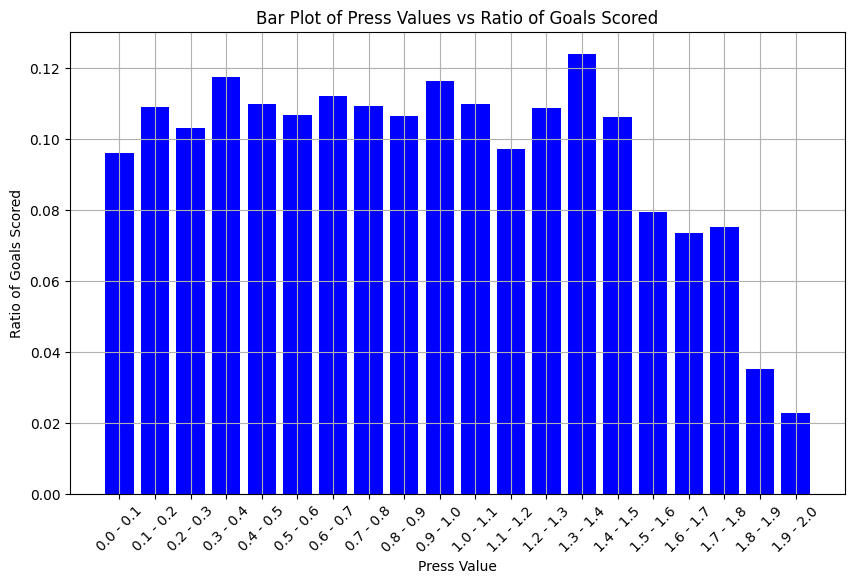

In [61]:
labels = [f"{i / 10:.1f} - {(i+1) / 10:.1f}" for i in range(0, len(ratios))]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, ratios, color='blue')
plt.xlabel('Press Value')
plt.ylabel('Ratio of Goals Scored')
plt.title('Bar Plot of Press Values vs Ratio of Goals Scored')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

In [62]:
ratios1 = []
for i in range(35):
    df = data[(data['influence_in_triangle'] >= i*0.5) & (data['influence_in_triangle'] < (i+1)*0.5) & (data["is_penalty"] == False)]
    yes_goals = len(df[df["is_goal"] == True])
    rate = yes_goals/len(df)
    ratios1.append(rate)     
ratios1

[0.18245768300725435,
 0.15867254342753434,
 0.22232734153263956,
 0.17017828200972449,
 0.1222757513191099,
 0.15205585725368503,
 0.16835699797160245,
 0.1989606533036377,
 0.13310580204778158,
 0.11986301369863013,
 0.1348142474147836,
 0.13446630888491354,
 0.1002209278971681,
 0.08050847457627118,
 0.08633980881899475,
 0.07191892775416803,
 0.07313195548489666,
 0.05279211637728766,
 0.04913848117421825,
 0.052060737527114966,
 0.05041698256254738,
 0.04844497607655503,
 0.047880299251870324,
 0.04669464847848898,
 0.0625,
 0.0497335701598579,
 0.04061470911086718,
 0.0434616850934045,
 0.018929150892374257,
 0.0420899854862119,
 0.020036429872495445,
 0.0,
 0.017456359102244388,
 0.0234375,
 0.0]

In [63]:
df = data[(data['influence_in_triangle'] >= 7) & (data['influence_in_triangle'] < 7.5)]
yes_goals = len(df[df["is_goal"] == True])
rate = yes_goals/len(df)
(df[(df["is_goal"] == True) & (df["is_penalty"] == False)][["period", "minute", "team", "play_pattern", "is_goal", "statsbomb_xg", "is_penalty", "defenders_triangle", "influence_in_triangle", "under_pressure"]])

,period,minute,team,play_pattern,is_goal,statsbomb_xg,is_penalty,defenders_triangle,influence_in_triangle,under_pressure
36,1.0,2.0,Washington Spirit,Regular Play,True,0.097241,False,1,7.253192,False
46,2.0,65.0,North Carolina Courage,Regular Play,True,0.057973,False,1,7.349680,True
321,2.0,61.0,NJ/NY Gotham FC,Regular Play,True,0.071452,False,2,7.352867,False
724,1.0,26.0,NJ/NY Gotham FC,Regular Play,True,0.509510,False,0,7.402766,False
891,2.0,52.0,Portland Thorns,From Throw In,True,0.495991,False,1,7.401263,False
...,...,...,...,...,...,...,...,...,...,...
82079,2.0,60.0,OGC Nice,Regular Play,True,0.126058,False,1,7.068500,False
82686,1.0,3.0,Côte d'Ivoire,From Counter,True,0.056426,False,2,7.417416,False
82989,2.0,45.0,Equatorial Guinea,From Goal Kick,True,0.151435,False,1,7.321815,False
82998,1.0,20.0,Equatorial Guinea,From Counter,True,0.434480,False,1,7.079254,False


In [64]:
ratios1[14]

0.08633980881899475

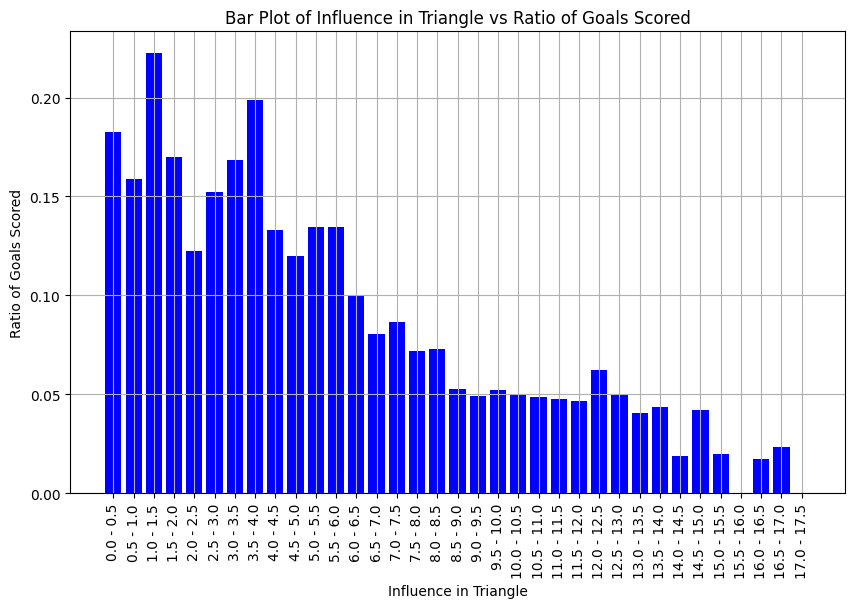

In [65]:
labels = [f"{i*0.5} - {(i+1)*0.5}" for i in range(0, len(ratios1))]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(labels, ratios1, color='blue')
plt.xlabel('Influence in Triangle')
plt.ylabel('Ratio of Goals Scored')
plt.title('Bar Plot of Influence in Triangle vs Ratio of Goals Scored')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.grid(True)
plt.show()

In [66]:
lengths = []
for i in range(35):
    df = data[(data['influence_in_triangle'] >= i*0.5) & (data['influence_in_triangle'] < (i+1)*0.5)]
    lengths.append(len(df))
lengths


[9098,
 3857,
 1057,
 1851,
 4359,
 1289,
 986,
 1347,
 3809,
 2336,
 2611,
 3354,
 5049,
 5007,
 4272,
 3124,
 1887,
 4263,
 3134,
 2766,
 2638,
 1672,
 2005,
 1906,
 992,
 1689,
 911,
 2623,
 1849,
 689,
 549,
 19,
 802,
 128,
 1]

In [67]:
ratios2 = []
for i in range(11):
    df = data[(data['defenders_triangle'] == i) &  (data["is_penalty"] == False)]
    yes_goals = len(df[df["is_goal"] == True])
    rate = yes_goals/len(df)
    ratios2.append(rate)     
ratios2

[0.3904863329783458,
 0.12985603143012225,
 0.059557403831872864,
 0.04575311438278596,
 0.049800796812749,
 0.047653958944281524,
 0.07637231503579953,
 0.09565217391304348,
 0.14285714285714285,
 0.3,
 0.0]

In [68]:
num = []
for i in range(7):
    num.append(i)

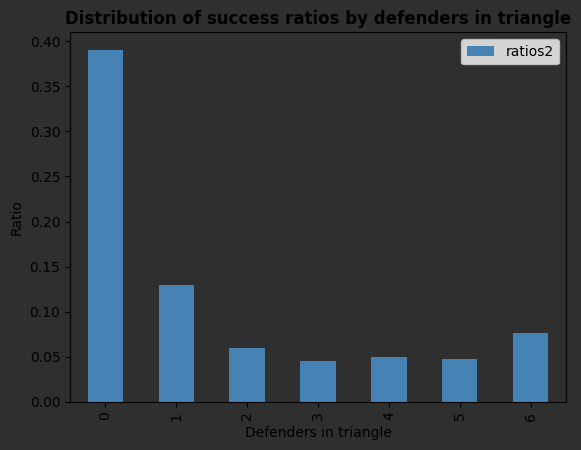

In [69]:
DF = pd.DataFrame()
DF['ratios2'] = ratios2[0:7]
DF['defenders_num'] = num
fig, ax = plt.subplots()
fig.patch.set_facecolor('#2f2f2f')  # Change the background color of the figure
ax.set_facecolor('#2f2f2f')  # Change the background color of the plot area

# Ensure the 'ax' from subplots is used for the plot
ax = DF.plot.bar(color="steelblue", x="defenders_num", y="ratios2", ax=ax)
ax.set_title('Distribution of success ratios by defenders in triangle', weight='bold')
ax.set_xlabel('Defenders in triangle')
ax.set_ylabel('Ratio')
plt.show()

In [70]:
num1 = []
for i in range(len(ratios1)):
    num1.append(i)
num1

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

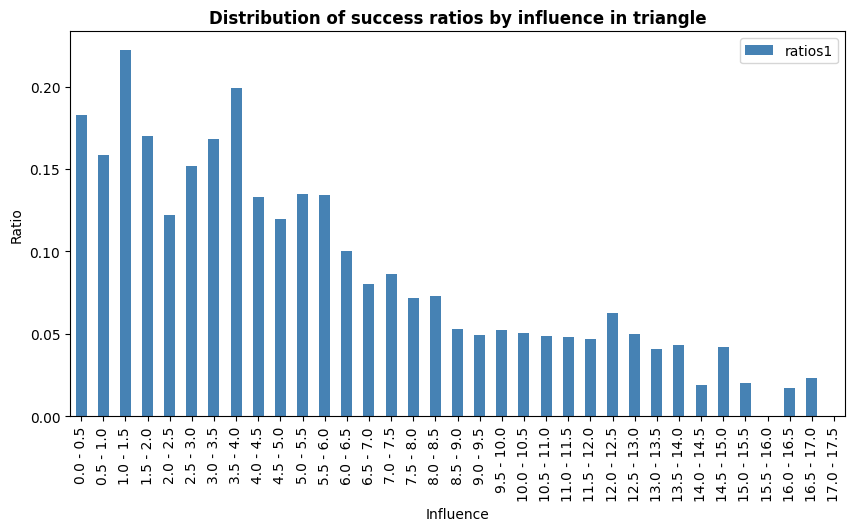

In [71]:
num1 = np.arange(0, 17.5, 0.5)  # Half steps from 0 to 17

DF = pd.DataFrame()
DF['ratios1'] = ratios1
DF['influence'] = num1

# Correcting the bin and label mismatch
bins = np.arange(0, 18, 0.5)  # Extends from 0 to 17.5, boundary at 17.5
labels = [f"{i} - {i+0.5}" for i in np.arange(0, 17.5, 0.5)]

DF['influence'] = pd.cut(DF['influence'], bins=bins, right=False, labels=labels)
ax = DF.plot.bar(color="steelblue", x='influence', y='ratios1', figsize=(10, 5))
ax.set_title('Distribution of success ratios by influence in triangle', weight='bold')
ax.set_xlabel('Influence')
ax.set_ylabel('Ratio')
plt.xticks(rotation=90)
plt.show()